## Springboard Capstone Project Data Wrangling 

To clean the data we must first check to see what the distribution of the data is across MBTI category types. Our next step will be to split each 'posts' entry up into individual entries categorized by MBTI type.

### 1. Visualization
First lets open up the csv file mbti_1.csv and take a peek at the first few entries.

In [4]:
#import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re

#read in csv as dataframe
data = pd.read_csv('mbti_1.csv')
mbti_df = pd.DataFrame(data)
print(mbti_df.head(10), mbti_df.shape)

   type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...
5  INTJ  '18/37 @.@|||Science  is not perfect. No scien...
6  INFJ  'No, I can't draw on my own nails (haha). Thos...
7  INTJ  'I tend to build up a collection of things on ...
8  INFJ  I'm not sure, that's a good question. The dist...
9  INTP  'https://www.youtube.com/watch?v=w8-egj0y8Qs||... (8675, 2)


We have a total of 8675 entires. As you can see we have some information that is useful and some that is not. It looks like theres a lot of strings with links, so I think that once we split up the entries into individual posts, I should remove all the links and numbers as they aren't human generated text and therefore shouldn't be included into the dataset.

Next let's check the total entries for each each personality catergory and then double check to make sure all 16 are represented and at what ratio.

In [5]:
#check total entries for each personality type
type_count = mbti_df.type.value_counts()
print(type_count)

#check to see if all 16 personalities are represented
type_count.shape

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64


(16,)

So far so good, all 16 MBTI category types are there. It looks like some of our trailing personality types are severely underrepresented to the point where there isn't nearly enough data to use in a classification model. On the other hand, each entry contains 50 separate posts, so for ESTJ for example, 39 posts will come out to 1,950 entries. We will run this step again once the posts are split to again check the distribution.

Here is the same data, plotted for visual. 

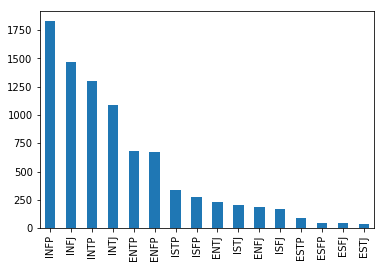

In [6]:
type_count.plot.bar(x='type')
plt.show()

### 2. Entry Splitting
The description of the dataset is that each entry in 'posts' column countains multiple comments seperated by '|||' characters. The conventions of datascience stipulate that we seperate rows into one distinct instance of data, so I will seperate each entry into a seperate row.

In [7]:
#to make filling in the type column easier when the entries are stacked, set the type as the index
mbti_df = mbti_df.set_index('type')

#split the entries by the '|||\ delimiter. note that each pipe character must be enclosed in [] do have it evaluated literally
mbti_df = mbti_df.posts.str.split('[|][|][|]', expand=True).stack()

#reset index, setting level=0 to unstack only the type since it's a multilevel index
mbti_df = mbti_df.reset_index(level=0)

#rename columns. idk why they were reset to default. 
mbti_df = mbti_df.rename(columns = {0:'posts'})

mbti_df.head(10)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,INFJ,enfp and intj moments https://www.youtube.com...
3,INFJ,What has been the most life-changing experienc...
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...
5,INFJ,May the PerC Experience immerse you.
6,INFJ,The last thing my INFJ friend posted on his fa...
7,INFJ,Hello ENFJ7. Sorry to hear of your distress. I...
8,INFJ,84389 84390 http://wallpaperpassion.com/uplo...
9,INFJ,Welcome and stuff.


### 3. Re-checking the Data
now supposedly there are 50 comments in every entry, so now that each comment has been split into a seperate entry, lets look at how many total entries we have per MBTI type. We would expect to have 8675 * 50 entries (433,750)

In [8]:
#check total entries for each personality type we have now
type_count = mbti_df.type.value_counts()
print(type_count, mbti_df.shape)


INFP    89796
INFJ    72105
INTP    63359
INTJ    52471
ENTP    33761
ENFP    32769
ISTP    16498
ISFP    13000
ENTJ    11273
ISTJ     9913
ENFJ     9288
ISFJ     8121
ESTP     4337
ESFP     2215
ESFJ     2018
ESTJ     1921
Name: type, dtype: int64 (422845, 2)


Seems like we fell a little short of 433,750, but 422,845 certainly gives us much more data to work with. Time to get to work cleaning the data.

### 4. Remove Escaping HTML Characters 
Next order of business should be to clean out escaping HTML characters, since this data was presumably collected from the web. escaping HTML characters can muck up code and cause unexpected problems, so let's get rid of them. From this point on, all clean data will reside in the mbti_df.clean_posts column.

In [9]:
import html

#remove escaping HTML characters and apply it across 'posts' column
mbti_df['clean_posts'] = html.unescape(mbti_df['posts'])

### 3. Remove Hyperlinks
Now that all the escaping characters have been removed, I noticed that many entries contained links. We won't be using those, so I'll go ahead and remove them.

In [10]:
def remove_links(entry):
    #removes all hyperlinks from data entries
    return re.sub(r"http\S+", '', entry)

mbti_df['clean_posts'] = mbti_df['clean_posts'].apply(remove_links)


### 4. Remove Contractions
Next I think all the contractions need to be removed. Just like escaping HTML charaters, apostrophies can really cause problems later down the road, so using a dictionary of contractions let's map all contractions to their regular english counterparts.

In [11]:
#here we have a dict of contractions to map to their word counterparts
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"Im" : "I am",
"IM" : "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"im" : "i am",    
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}
 #define a function to replace contractions in mbti_df.posts with whole words
def contraction_replace(entry):
    words = entry.split()
    reformed = [CONTRACTION_MAP[word.lower()] if word.lower() in CONTRACTION_MAP else word for word in words]
    return " ".join(reformed)

mbti_df['clean_posts'] = mbti_df['clean_posts'].apply(contraction_replace)

mbti_df.head(10)


,type,posts,clean_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw,'
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,
2,INFJ,enfp and intj moments https://www.youtube.com...,enfp and intj moments sportscenter not top ten...
3,INFJ,What has been the most life-changing experienc...,What has been the most life-changing experienc...
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,On repeat for most of today.
5,INFJ,May the PerC Experience immerse you.,May the PerC Experience immerse you.
6,INFJ,The last thing my INFJ friend posted on his fa...,The last thing my INFJ friend posted on his fa...
7,INFJ,Hello ENFJ7. Sorry to hear of your distress. I...,Hello ENFJ7. Sorry to hear of your distress. i...
8,INFJ,84389 84390 http://wallpaperpassion.com/uplo...,84389 84390 ...
9,INFJ,Welcome and stuff.,Welcome and stuff.


### 7. Remove Digits and Punctuation
I still see digits and odd punctuation. Since neither of those will aid in the text analsis later, let's remove them.

In [12]:
#define a funtion to remove all digits from entries. we dont need them for text analysis
def remove_digits(entry):
    return re.sub('\d', '', entry)

#remove all links and digits in dataframe by applying remove_links and remove_digits
mbti_df['clean_posts'] = mbti_df['clean_posts'].apply(remove_digits)

#remove punctation
mbti_df['clean_posts'] = mbti_df['clean_posts'].str.replace('[^\w\s]','')


## 8. Filter Out Empty Entries
Removing numbers and links resulted in a lot of entries filled with empty strings. lets filter out those useless entries

In [13]:
#select only entries with non-empy strings
mbti_df = mbti_df[mbti_df.clean_posts != '']

#I noticed one odd cell in row 8 that remained blank, looks like it might have a few spaces as an entry
mbti_df = mbti_df[mbti_df.clean_posts != '  ']

### 9. Remove Stopwords
Now lets remove all the stop words in the dataframe. Stopwords are words that don't really contribute anything useful to the text analysis so I'll just remove them completely.

In [14]:
stop = set(stopwords.words('english'))

#remove all stopwords. the stopwords set is in lowercase, so use .lower() to make sure nothing with in uppercase is missed.
mbti_df['clean_posts'] = mbti_df['clean_posts'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in (stop)]))

mbti_df.head(10)

,type,posts,clean_posts
2,INFJ,enfp and intj moments https://www.youtube.com...,enfp intj moments sportscenter top ten plays p...
3,INFJ,What has been the most life-changing experienc...,lifechanging experience life
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,repeat today
5,INFJ,May the PerC Experience immerse you.,may perc experience immerse
6,INFJ,The last thing my INFJ friend posted on his fa...,last thing infj friend posted facebook committ...
7,INFJ,Hello ENFJ7. Sorry to hear of your distress. I...,hello enfj sorry hear distress natural relatio...
9,INFJ,Welcome and stuff.,welcome stuff
10,INFJ,http://playeressence.com/wp-content/uploads/20...,game set match
11,INFJ,"Prozac, wellbrutin, at least thirty minutes of...",prozac wellbrutin least thirty minutes moving ...
12,INFJ,Basically come up with three items you've dete...,basically come three items determined type whi...


### 10. Re-check Data
So far so good! The data looks like its ready for vectorization. Before moving on, let's take a look at the data is broken down now that it is clean. 

In [15]:
value_count = mbti_df.type.value_counts()
print(mbti_df.shape, value_count.shape)

(409165, 3) (16,)


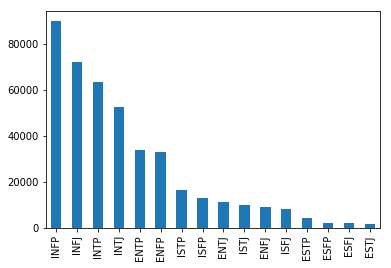

In [16]:
type_count.plot.bar(x='type')
plt.show()

Looking at this graph, there is a very clear bias in our data that might need to be accounted for. 

### 11. Export Cleaned Data set
Export the cleaned data set to directory.

In [19]:
mbti_df.to_csv('mbti_cleaned.csv')